In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from data_manager import *
from metadata import *

import matplotlib.pyplot as plt
%matplotlib inline

Setting environment for Gordon


In [5]:
from skimage.filters import threshold_otsu
from scipy.ndimage import label
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed, binary_dilation, disk
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.measure import regionprops
from sklearn.cluster import KMeans

In [ ]:
im = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_cells/example/brainstem.png', True)

t = time.time()

thresh = threshold_otsu(im)
binary = im < thresh

sys.stderr.write('threshold: %.2f\n' % (time.time() - t) )

# plt.imshow(binary, cmap=plt.cm.gray);
# plt.axis('off');
# plt.title('binary');

t = time.time()
dt = distance_transform_edt(binary)
sys.stderr.write('distance transform: %.2f\n' % (time.time() - t) )

# plt.imshow(dt, cmap=plt.cm.gray);
# plt.axis('off');
# plt.title('distance tranform');

t = time.time()
local_maxi = peak_local_max(dt, labels=binary, footprint=np.ones((10, 10)), indices=False)
sys.stderr.write('local max: %.2f\n' % (time.time() - t) )

# plt.imshow(local_maxi, cmap=plt.cm.gray);
# plt.axis('off');
# plt.title('local maxima');

t = time.time()
markers = label(local_maxi)[0]
sys.stderr.write('label: %.2f\n' % (time.time() - t) )

t = time.time()
labels = watershed(-dt, markers, mask=binary)
sys.stderr.write('watershed: %.2f\n' % (time.time() - t) )

# plt.imshow(labels);
# plt.axis('off');
# plt.title('labels');

t = time.time()
props = regionprops(labels)
sys.stderr.write('regionprops: %.2f\n' % (time.time() - t) )

valid_indices = [i for i, p in enumerate(props) if p.area > 40 and p.area < 1000]
print len(valid_indices)

# replace invalid indices with 0
# new_labels = np.reshape([l if l-1 in valid_indices else 0 for l in labels.flat], labels.shape)

t = time.time()

# region_features = [np.r_[props[i].moments_central[0,0], np.nan_to_num(props[i].moments_normalized.flatten())] 
#                    for i in valid_indices]
region_features = np.array([np.r_[props[i].moments_central[0,0], np.nan_to_num(props[i].moments_hu.flatten())] 
                   for i in valid_indices])
region_features = (region_features - region_features.mean(axis=0)) / region_features.std(axis=0)
#     region_features[:,0] = (region_features[:,0] - region_features[:,0].mean(axis=0)) / region_features[:,0].std(axis=0)

sys.stderr.write('regionprops: %.2f\n' % (time.time() - t) )

valid_props = [props[i].coords for i in valid_indices]

#     pickle.dump(valid_props, open('/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_blobCoords.pkl' % {'stack': stack, 'sec': sec}, 'w'))
#     bp.pack_ndarray_file(region_features, '/home/yuncong/csd395/CSHL_cells/%(stack)s_%(sec)04d_features.bp' % {'stack': stack, 'sec': sec})

In [30]:
colors = np.array(random_colors(labels.max()+1))
colors[0] = (0,0,0)

In [35]:
im_boundaryMarked = mark_boundaries(im, labels, color=(1,0,0))

In [37]:
display_image(im_boundaryMarked)

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


/oasis/projects/nsf/csd395/yuncong/Brain/cells/tmp.jpg

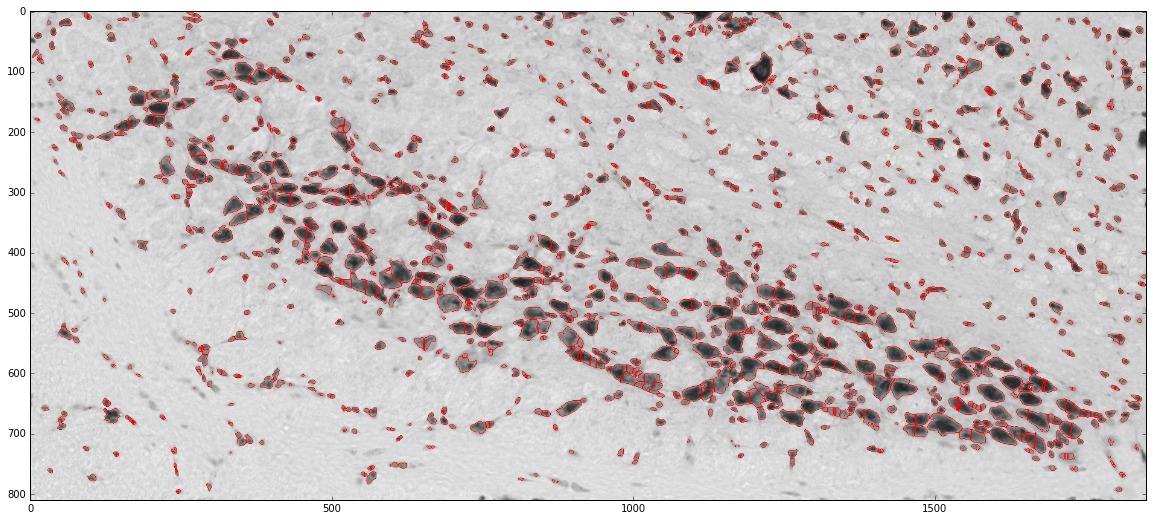

In [36]:
plt.figure(figsize=(20,20));
# plt.imshow(colors[labels]);
plt.imshow(im_boundaryMarked);